In [1]:
!pip install -q sdv sdmetrics scikit-learn pandas numpy matplotlib
import numpy as np, pandas as pd, matplotlib.pyplot as plt
np.random.seed(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.8/186.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.4/198.4 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.4 MB/s eta 0:00:00


In [2]:
N = 200
age = np.r_[np.random.randint(25,61, int(N*0.7)),
            np.random.randint(65,91, N - int(N*0.7))]
sex = np.random.choice(['male','female'], N)

height = np.clip(np.random.normal(172, 9, N), 150, 195)
weight = np.clip(np.random.normal(72, 14, N), 45, 120)
bmi = weight / (height**2) * 10000

sbp = np.clip(110 + 0.35*(age-40) + np.random.normal(0,12,N), 90, 200)
pp  = np.clip(np.random.normal(50,12,N), 30, 90)   # pulse pressure
dbp = np.clip(sbp - pp, 50, 120)

hr  = np.clip(75 + 0.06*(age-40) + np.random.normal(0,8,N), 45, 120)
temp = np.where(np.random.rand(N) < 0.02,
                np.random.normal(38.4,0.3,N),
                np.random.normal(36.8,0.3,N))
temp = np.clip(temp, 35.0, 40.0)
spo2 = np.clip(np.random.normal(97,1.5,N), 88, 100)

df_seed = pd.DataFrame({
    'age_years': age, 'sex': sex, 'height_cm': height, 'weight_kg': weight, 'bmi': bmi,
    'resting_hr_bpm': hr, 'systolic_bp_mmHg': sbp, 'diastolic_bp_mmHg': dbp,
    'temp_c': temp, 'spo2_pct': spo2
})
df_seed.head()


,age_years,sex,height_cm,weight_kg,bmi,resting_hr_bpm,systolic_bp_mmHg,diastolic_bp_mmHg,temp_c,spo2_pct
0,53,female,180.146098,73.608061,22.681703,67.527390,116.716370,77.187938,37.010722,98.832701
1,39,female,166.564861,93.717680,33.779620,70.705614,141.372859,81.848964,36.829025,99.624372
2,32,male,174.740042,74.379621,24.359540,79.469492,104.765845,58.370171,36.767135,95.478372
3,45,female,174.314867,88.145433,29.008879,84.334596,112.312985,71.970428,36.618796,98.174305
4,43,male,172.215386,86.372118,29.122568,98.900083,132.435963,94.509354,37.065382,95.551753


In [3]:
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.cag import Inequality

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df_seed)   # no table_name here

synth = GaussianCopulaSynthesizer(metadata)
synth.add_constraints([
    Inequality(low_column_name='diastolic_bp_mmHg',
               high_column_name='systolic_bp_mmHg',
               strict_boundaries=True)
])
synth.fit(df_seed)
df_syn = synth.sample(num_rows=2500)


/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [10]:
!pip install -U sdv sdmetrics
from sdv.metadata import Metadata
df_seed['row_id'] = range(1, len(df_seed) + 1) # Add row_id to df_seed
metadata = Metadata.detect_from_dataframe(data=df_seed, table_name='vitals')

(2/2) Evaluating Column Pair Trends: |█▏        | 9/78 [01:28<11:16,  9.80s/it]|


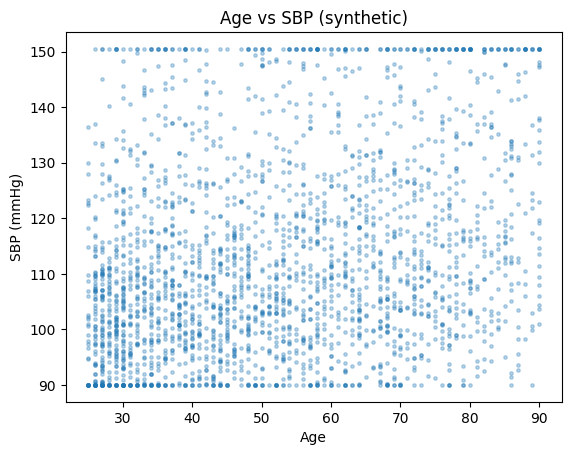

In [11]:
df_syn['row_id'] = range(1, len(df_syn) + 1) # Add row_id to df_syn
df_seed['age_65plus'] = (df_seed['age_years'] >= 65).astype(int) # Add age_65plus to df_seed
df_syn['age_65plus'] = (df_syn['age_years'] >= 65).astype(int) # Add age_65plus to df_syn

df_seed['hypertension_flag'] = ( # Add hypertension_flag to df_seed
    (df_seed['systolic_bp_mmHg'] >= 130) | (df_seed['diastolic_bp_mmHg'] >= 80)
).astype(int)  # AHA Stage1+ cut-points
df_syn['hypertension_flag'] = ( # Add hypertension_flag to df_syn
    (df_syn['systolic_bp_mmHg'] >= 130) | (df_syn['diastolic_bp_mmHg'] >= 80)
).astype(int)  # AHA Stage1+ cut-points

metadata = Metadata.detect_from_dataframe(data=df_seed, table_name='vitals') # Regenerate metadata

plt.scatter(df_syn['age_years'], df_syn['systolic_bp_mmHg'], s=6, alpha=0.3)
plt.xlabel('Age'); plt.ylabel('SBP (mmHg)'); plt.title('Age vs SBP (synthetic)')
plt.show()

In [14]:
from sdmetrics.reports.single_table import QualityReport, DiagnosticReport
qr = QualityReport(); qr.generate(df_seed, df_syn, metadata.to_dict()['tables']['vitals'])
print('Quality score:', round(qr.get_score(), 3))            # higher ~ better
dr = DiagnosticReport(); dr.generate(df_seed, df_syn, metadata.to_dict()['tables']['vitals'])
print("Data Validity Details:")
display(dr.get_details('Data Validity').head())                              # look for issues
print("\nData Structure Details:")
display(dr.get_details('Data Structure').head())

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 13/13 [00:00<00:00, 111.20it/s]|
Column Shapes Score: 92.58%

(2/2) Evaluating Column Pair Trends: |██████████| 78/78 [00:00<00:00, 210.63it/s]|
Column Pair Trends Score: 92.59%

Overall Score (Average): 92.59%

Quality score: 0.926
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 13/13 [00:00<00:00, 1361.31it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 244.22it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Data Validity Details:


,Column,Metric,Score
0,row_id,KeyUniqueness,1.0
1,age_years,BoundaryAdherence,1.0
2,sex,CategoryAdherence,1.0
3,height_cm,BoundaryAdherence,1.0
4,weight_kg,BoundaryAdherence,1.0



Data Structure Details:


,Metric,Score
0,TableStructure,1.0


In [15]:
# Shapes & columns
print("seed:", df_seed.shape, "syn:", df_syn.shape)
assert set(df_seed.columns) == set(df_syn.columns), "Columns mismatch"

# Primary key sanity (if you added row_id)
assert df_seed['row_id'].is_unique and df_syn['row_id'].is_unique

# Constraint check: DBP < SBP
assert (df_syn['systolic_bp_mmHg'] > df_syn['diastolic_bp_mmHg']).all()


seed: (200, 13) syn: (2500, 13)


In [16]:
from sdmetrics.reports.single_table import DiagnosticReport
dr = DiagnosticReport()
dr.generate(real_data=df_seed, synthetic_data=df_syn, metadata=meta_dict)

print(dr.get_properties())                # {'Data Validity': 1.0, 'Data Structure': 1.0} is ideal
display(dr.get_details('Data Validity'))  # see per-column checks
display(dr.get_details('Data Structure'))


Generating report ...

(1/2) Evaluating Data Validity: |██████████| 13/13 [00:00<00:00, 256.12it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 109.81it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

         Property  Score
0   Data Validity    1.0
1  Data Structure    1.0


,Column,Metric,Score
0,age_years,BoundaryAdherence,1.0
1,sex,CategoryAdherence,1.0
2,height_cm,BoundaryAdherence,1.0
3,weight_kg,BoundaryAdherence,1.0
4,bmi,BoundaryAdherence,1.0
5,resting_hr_bpm,BoundaryAdherence,1.0
6,systolic_bp_mmHg,BoundaryAdherence,1.0
7,diastolic_bp_mmHg,BoundaryAdherence,1.0
8,temp_c,BoundaryAdherence,1.0
9,spo2_pct,BoundaryAdherence,1.0


,Metric,Score
0,TableStructure,1.0


In [17]:
from sdmetrics.reports.single_table import QualityReport
qr = QualityReport()
qr.generate(real_data=df_seed, synthetic_data=df_syn, metadata=meta_dict)

print("Overall quality:", round(qr.get_score(), 3))
display(qr.get_properties())   # {'Column Shapes': x, 'Column Pair Trends': y}

# Drill down
cs = qr.get_details('Column Shapes')         # per-column scores & which metric (KSComplement/TVComplement)
cpt = qr.get_details('Column Pair Trends')   # per pair of columns
display(cs.head()); display(cpt.head())

# Optional: interactive plots (works in Colab)
fig = qr.get_visualization('Column Shapes'); fig.show()
fig2 = qr.get_visualization('Column Pair Trends'); fig2.show()


Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 13/13 [00:00<00:00, 558.80it/s]|
Column Shapes Score: 92.58%

(2/2) Evaluating Column Pair Trends: |██████████| 78/78 [00:00<00:00, 209.10it/s]|
Column Pair Trends Score: 92.59%

Overall Score (Average): 92.59%

Overall quality: 0.926


,Property,Score
0,Column Shapes,0.925800
1,Column Pair Trends,0.925915


,Column,Metric,Score
0,age_years,KSComplement,0.9474
1,sex,TVComplement,0.9810
2,height_cm,KSComplement,0.9596
3,weight_kg,KSComplement,0.9566
4,bmi,KSComplement,0.8144


,Column 1,Column 2,Metric,Score,Real Correlation,Synthetic Correlation
0,age_years,sex,ContingencySimilarity,0.858800,NaN,NaN
1,age_years,height_cm,CorrelationSimilarity,0.986704,-0.025600,0.000991
2,age_years,weight_kg,CorrelationSimilarity,0.985504,0.094490,0.123483
3,age_years,bmi,CorrelationSimilarity,0.994859,0.094509,0.104790
4,age_years,resting_hr_bpm,CorrelationSimilarity,0.989034,0.194178,0.216110


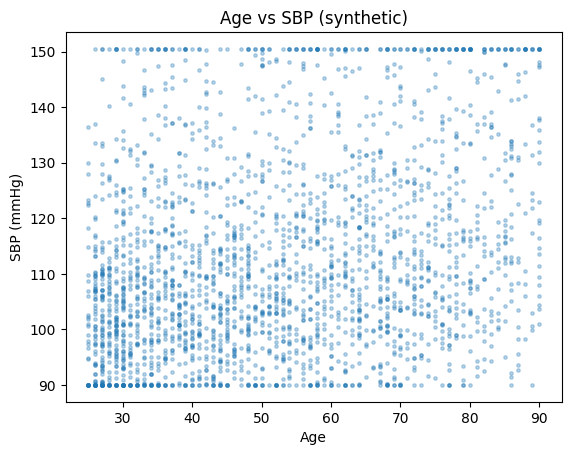

In [18]:
import matplotlib.pyplot as plt
plt.scatter(df_syn['age_years'], df_syn['systolic_bp_mmHg'], s=6, alpha=0.3)
plt.xlabel('Age'); plt.ylabel('SBP (mmHg)'); plt.title('Age vs SBP (synthetic)'); plt.show()


In [19]:
# Save/load quality report
qr.save('quality_report.pkl')
loaded = QualityReport.load('quality_report.pkl')
print("Loaded score:", loaded.get_score())


Loaded score: 0.9258574147795533


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

X = df_syn[['bmi','resting_hr_bpm','systolic_bp_mmHg','diastolic_bp_mmHg','spo2_pct','temp_c','age_years']]
y = df_syn['age_65plus']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, pred), 3))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))


Accuracy: 0.992
Confusion matrix:
 [[442   1]
 [  4 178]]


In [21]:
# Ensure df_syn is defined by re-running the synthesis cell if necessary
# Assuming the synthesis cell (eQaV4LbxhcsA) was run previously but runtime might have reset
# Or if cells were run out of order, re-running the synthesis and subsequent cells is needed.
# Since df_syn is visible in the kernel state, we can proceed with saving.

df_syn.to_csv('vitals_lite.csv', index=False)